STEP 0: IMPORT NECESSARY LIBRARIES

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
df = pd.read_csv("/content/xy_train.csv")
df.head()

,ID,text,label
0,0,Americans Aren't Sure If Flight 370 Vanished T...,1
1,1,Pope Leo X offering indulgences to sinners sho...,0
2,2,News: 5 Uplifting Hypotheticals Of What Could ...,0
3,3,George W. Bush and Jeb Bush at a campaign stop...,0
4,4,The WADA requesting their fair share from Lanc...,0


STEP 1: PREPROCESSING OUR TEXT

In [ ]:
# Setup
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def tokenize_and_clean(text):
    if pd.isnull(text):
        return []

    # Remove non-English characters and digits
    text = re.sub(r"[^a-zA-Z\s]", " ", text)

    # Lowercase and tokenize
    tokens = nltk.word_tokenize(text.lower())

    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens

def process_df_token_column(df):
    if 'text' not in df.columns:
        raise ValueError("DataFrame must contain a 'text' column")

    df['text'] = df['text'].apply(tokenize_and_clean)
    return df

In [ ]:
process_df_token_column(df)

In [ ]:
df.isnull().sum()

STEP 2: VECTORIZATION

In [ ]:

def vectorize_df_count(df):
    if 'text' not in df.columns:
        raise ValueError("DataFrame must contain a 'text' column")

    # Join token lists into strings
    def join_tokens(x):
        if isinstance(x, list) and len(x) > 0:
            return ' '.join(str(token) for token in x if token)
        return ''

    df['text_str'] = df['text'].apply(join_tokens)

    # Check for valid texts
    valid_texts = df['text_str'][df['text_str'] != '']
    if len(valid_texts) == 0:
        raise ValueError("No valid text data to vectorize")

    # Initialize CountVectorizer
    count_vectorizer = CountVectorizer(
        max_features=5000,
        lowercase=False,  # No lowercasing
        tokenizer=lambda x: x.split(),  # Use split to respect pre-tokenized words
        preprocessor=lambda x: x,  # No preprocessing
        token_pattern=None,  # Disable default token pattern
        min_df=1,  # Include all terms
        stop_words=None  # No stop words
    )

    # Fit and transform valid texts
    count_matrix = count_vectorizer.fit_transform(valid_texts)

    # Create DataFrame for count features, initialize with zeros
    count_df = pd.DataFrame(
        0,
        index=df.index,
        columns=[f'count_{i}' for i in range(count_matrix.shape[1])]
    )

    # Populate count values for valid rows
    valid_indices = valid_texts.index
    count_df.loc[valid_indices] = count_matrix.toarray()

    # Drop temporary text_str column
    df = df.drop(columns=['text_str'])

    # Concatenate original DataFrame with count features
    df = pd.concat([df, count_df], axis=1)

    # Debug: Print vocabulary info
    feature_names = count_vectorizer.get_feature_names_out()
    print("Vocabulary size:", len(feature_names))
    print("Sample feature names:", feature_names[:10])
    print("Sample text_str for comparison:", df['text'].head().apply(join_tokens).tolist())

    return df

STEP 3: TRANING

In [13]:


def split_train_test(df, test_size=0.2, random_state=42):
    # Identify feature columns (all count_ columns)
    feature_cols = [col for col in df.columns if col.startswith('count_')]

    # Define features (X) and target (y)
    X = df[feature_cols]  # Vectorized features
    y = df['label']       # Target variable

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=test_size,    # 20% for testing, 80% for training
        random_state=random_state,  # For reproducibility
        stratify=y              # Ensure label distribution is preserved
    )

    # Create training and testing DataFrames (optional, if you need them)
    train_df = df.loc[X_train.index].copy()
    test_df = df.loc[X_test.index].copy()

    return X_train, X_test, y_train, y_test, train_df, test_df

# Usage
X_train, X_test, y_train, y_test, train_df, test_df = split_train_test(df)
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)
print("Training DataFrame head:\n", train_df.head())
print("Testing DataFrame head:\n", test_df.head())

Training set shape: (38400, 1000) (38400,)
Testing set shape: (9600, 1000) (9600,)
Training DataFrame head:
           ID                                               text  label  \
18501  18501  [swedish, propaganda, alcohol, prohibition, cr...      0   
31985  31985  [sign, hotel, elevator, weight, limit, give, m...      1   
40421  40421  [way, rock, tanline, line, horizon, led, belie...      0   
25523  25523  [poor, guy, looking, man, think, little, best,...      0   
14331  14331  [kkk, member, provide, cult, sense, pride, acc...      0   

       count_0  count_1  count_2  count_3  count_4  count_5  count_6  ...  \
18501        0        0        0        0        0        0        0  ...   
31985        0        0        0        0        0        0        0  ...   
40421        0        0        0        0        0        0        0  ...   
25523        0        1        0        0        1        0        0  ...   
14331        0        0        0        0        0        0  

STEP 4: MODEL EVALUATION

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
from collections import Counter

def vectorize_df_optimized(df, max_features=5000):
    if 'text' not in df.columns:
        raise ValueError("DataFrame must contain a 'text' column")

    # Join token lists into strings
    def join_tokens(x):
        if isinstance(x, list) and len(x) > 0:
            return ' '.join(str(token) for token in x if token)
        return ''

    df['text_str'] = df['text'].apply(join_tokens)

    # Build vocabulary from all tokens
    all_tokens = []
    for tokens in df['text']:
        if isinstance(tokens, list):
            all_tokens.extend([str(token) for token in tokens if token])

    # Get top max_features terms by frequency
    token_counts = Counter(all_tokens)
    vocab = [term for term, _ in token_counts.most_common(max_features)]

    # Debug: Print vocabulary info
    print("Vocabulary size:", len(vocab))
    print("Sample vocabulary:", vocab[:10])

    # Initialize CountVectorizer with precomputed vocabulary
    vectorizer = CountVectorizer(
        vocabulary=vocab,  # Use precomputed vocabulary
        lowercase=False,   # No lowercasing
        tokenizer=lambda x: x.split(),  # Split on spaces
        preprocessor=lambda x: x,       # No preprocessing
        token_pattern=None             # Disable default pattern
    )

    # Fit and transform text_str
    count_matrix = vectorizer.fit_transform(df['text_str'])

    # Convert to DataFrame
    count_df = pd.DataFrame(
        count_matrix.toarray(),
        index=df.index,
        columns=[f'count_{i}' for i in range(len(vocab))]
    )

    # Drop temporary text_str column
    df = df.drop(columns=['text_str'])

    # Concatenate original DataFrame with count features
    df = pd.concat([df, count_df], axis=1)

    return df

def split_train_test(df, test_size=0.2, random_state=42):
    feature_cols = [col for col in df.columns if col.startswith('count_')]
    if not feature_cols:
        raise ValueError("No 'count_' columns found in DataFrame")
    X = df[feature_cols]
    y = df['label']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    train_df = df.loc[X_train.index].copy()
    test_df = df.loc[X_test.index].copy()
    return X_train, X_test, y_train, y_test, train_df, test_df

# Main workflow
# Drop old count_ columns (if any)
df = df[[col for col in df.columns if not col.startswith('count_')]]

# Re-vectorize (optimized)
df = vectorize_df_optimized(df, max_features=1000)  # Reduced for speed; adjust as needed

# Split the data
X_train, X_test, y_train, y_test, train_df, test_df = split_train_test(df)

# Train a model
model = LogisticRegression(random_state=42, max_iter=500, class_weight='balanced', solver='liblinear')
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate
print("Training Accuracy:", accuracy_score(y_train, model.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Vocabulary size: 1000
Sample vocabulary: ['year', 'one', 'like', 'new', 'man', 'trump', 'u', 'colorized', 'people', 'first']
Training Accuracy: 0.7499479166666667
Test Accuracy: 0.7271875
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.72      0.75      5160
           1       0.72      0.74      0.73      4403
           2       0.03      0.22      0.05        37

    accuracy                           0.73      9600
   macro avg       0.51      0.56      0.51      9600
weighted avg       0.75      0.73      0.74      9600



ROC-AUC Score: 0.7655395310587028
Precision: 0.7458686189399685
Recall: 0.7271875
F1 Score: 0.7357041483753689
Confusion Matrix:
 [[3733 1272  155]
 [1058 3240  105]
 [  20    9    8]]


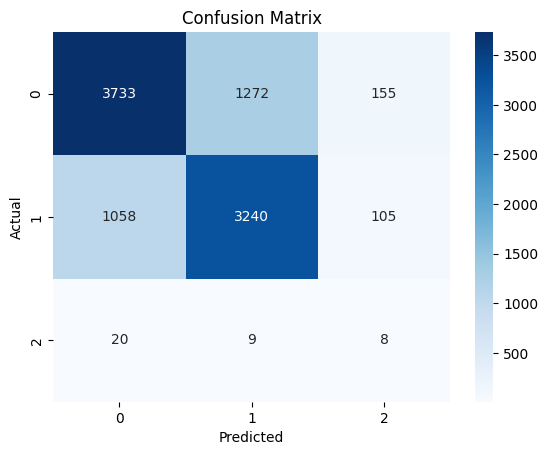

Cross-Validation ROC-AUC Scores: [0.77786784 0.73568156 0.77573671 0.75302595 0.76464935]
Mean CV ROC-AUC Score: 0.7613922814524992


In [15]:
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score,
    f1_score, confusion_matrix
)
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Get predicted probabilities for each class (multiclass case)
y_pred_proba = model.predict_proba(X_test)  # shape: [n_samples, n_classes]

# ROC-AUC Score for multiclass
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')  # or multi_class='ovo'
print("ROC-AUC Score:", roc_auc)

# Precision, Recall, F1 (set average for multiclass)
precision = precision_score(y_test, y_pred, average='weighted')  # or 'macro'
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Combine train and test sets for cross-validation
X_all = np.concatenate((X_train, X_test))
y_all = np.concatenate((y_train, y_test))

# Cross-Validation (use scoring='roc_auc_ovr' for multiclass)
cv_scores = cross_val_score(model, X_all, y_all, cv=5, scoring='roc_auc_ovr')
print("Cross-Validation ROC-AUC Scores:", cv_scores)
print("Mean CV ROC-AUC Score:", cv_scores.mean())


STEP 5: TESTING

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


# Re-define preprocessing function (from your original code)
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def tokenize_and_clean(text):
    if pd.isna(text):
        return []
    text = re.sub(r"[^a-zA-Z\s]", " ", text)
    tokens = nltk.word_tokenize(text.lower())
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

# Function to test custom text
def predict_custom_text(model, custom_text, vectorizer=None, vocab=None):
    # Step 1: Preprocess the custom text
    tokens = tokenize_and_clean(custom_text)
    text_str = ' '.join(tokens)  # Convert tokens to string for vectorization

    # Step 2: Vectorize the text
    if vectorizer is not None:
        # Use CountVectorizer with the same vocabulary
        X_custom = vectorizer.transform([text_str])
        feature_names = vectorizer.get_feature_names_out()
    elif vocab is not None:
        # Use custom vocabulary (if vectorizer isn't available)
        token_counts = Counter(tokens)
        X_custom = np.zeros((1, len(vocab)))
        for term, freq in token_counts.items():
            if term in vocab:
                col_idx = vocab.index(term)
                X_custom[0, col_idx] = freq
        feature_names = [f'count_{i}' for i in range(len(vocab))]
    else:
        raise ValueError("Either vectorizer or vocab must be provided")

    # Step 3: Predict
    prediction = model.predict(X_custom)[0]
    probability = model.predict_proba(X_custom)[0]  # [P(real), P(fake)]

    # Print results
    print("Custom Text:", custom_text)
    print("Processed Tokens:", tokens)
    print("Prediction (0=Real, 1=Fake):", prediction)
    print("Probability (Real, Fake):", probability)

    return prediction, probability

# Example usage
# Assuming you have the trained model and the vectorizer used during training
# If you used vectorize_df_optimized, recreate the vectorizer with the same vocabulary
all_tokens = []
for tokens in df['text']:
    if isinstance(tokens, list):
        all_tokens.extend([str(token) for token in tokens if token])
token_counts = Counter(all_tokens)
vocab = [term for term, _ in token_counts.most_common(1000)]  # Match max_features=1000

vectorizer = CountVectorizer(
    vocabulary=vocab,
    lowercase=False,
    tokenizer=lambda x: x.split(),
    preprocessor=lambda x: x,
    token_pattern=None
)

# Fit vectorizer on training data (needed for transform)
vectorizer.fit(df['text'].apply(lambda x: ' '.join(x) if isinstance(x, list) else ''))





CountVectorizer(lowercase=False,
                preprocessor=<function <lambda> at 0x7ac8e71e11c0>,
                token_pattern=None,
                tokenizer=<function <lambda> at 0x7ac8e71e1120>,
                vocabulary=['year', 'one', 'like', 'new', 'man', 'trump', 'u',
                            'colorized', 'people', 'first', 'look', 'old',
                            'say', 'get', 'poster', 'time', 'found', 'day',
                            'war', 'woman', 'life', 'make', 'e', 'world', 'c',
                            'american', 'psbattle', 'state', 'post', 'two', ...])

0 - True news, 1 - False news

In [ ]:
# Test custom false text (not from dataset)
custom_text = "Aliens have landed in New York and are offering free rides to Mars"
prediction, probability = predict_custom_text(model, custom_text, vectorizer=vectorizer)

In [17]:
# Test using a true text (from dataset)
custom_text = "Researchers Forced To Scrap Another Sleep Study After Participants Murdered In Dreams By Serial Killer"
prediction, probability = predict_custom_text(model, custom_text, vectorizer=vectorizer)

Custom Text: Researchers Forced To Scrap Another Sleep Study After Participants Murdered In Dreams By Serial Killer
Processed Tokens: ['researcher', 'forced', 'scrap', 'another', 'sleep', 'study', 'participant', 'murdered', 'dream', 'serial', 'killer']
Prediction (0=Real, 1=Fake): 0
Probability (Real, Fake): [6.28932698e-01 3.70925981e-01 1.41321745e-04]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
